In [123]:
# Import the required libraries
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas

In [124]:
# Read in Crypto Data
file2 = Path('../datasets/btc_df_min.csv')
btc_df = pd.read_csv(file2)



file3 = Path('../datasets/btc_sentiment_minute.csv')
btc_tw_df = pd.read_csv(file3)
btc_tw_df


,Date,nltk_polarity
0,2022-06-06 04:13:00+00:00,0.164000
1,2022-06-06 04:14:00+00:00,0.045167
2,2022-06-06 04:15:00+00:00,-0.005493
3,2022-06-06 04:16:00+00:00,0.005924
4,2022-06-06 04:17:00+00:00,0.225240
...,...,...
1789,2022-06-07 10:02:00+00:00,0.100042
1790,2022-06-07 10:03:00+00:00,0.074920
1791,2022-06-07 10:04:00+00:00,0.090621
1792,2022-06-07 10:05:00+00:00,-0.000779


In [125]:
from datetime import datetime, timedelta
now = datetime.now()

def hour_rounder(t):
    t = datetime.fromisoformat(t)
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

def min_rounder(t):
    t = datetime.fromisoformat(t)
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=t.minute, hour=t.hour)
               +timedelta(hours=t.second//30))


btc_df = btc_df.reset_index().drop(columns=['index'])
btc_df['rounded_date'] = btc_df['date'].apply(lambda t: min_rounder(t))
btc_tw_df['Date'] = btc_tw_df['Date'].apply(lambda t: min_rounder(t))
btc_df = btc_df.drop(columns='date')

btc_df = btc_df[['rounded_date', 'close']]




In [126]:
btc_tw_df['Date'] = btc_tw_df['Date'].dt.tz_localize(None)


In [127]:
total_data = btc_df.merge(btc_tw_df, left_on='rounded_date', right_on='Date') 
total_data = total_data.set_index('rounded_date')
total_data = total_data.drop(columns='Date')
total_data = total_data.rename(columns={'nltk_polarity': 'polarity'})
total_data.head()


,close,polarity
rounded_date,,
2022-06-06 11:00:00,41483.04,0.152029
2022-06-06 11:01:00,41449.72,0.256154
2022-06-06 11:02:00,41473.54,0.213744
2022-06-06 11:03:00,41485.81,0.382550
2022-06-06 11:04:00,41504.49,0.213087


In [128]:
# Calculate the hourly returns using the closing prices and the pct_change function
btc_df["actual_returns"] = btc_df["close"].pct_change()
btc_df = btc_df.dropna()
btc_df.head()


,rounded_date,close,actual_returns
1,2022-06-06 11:01:00,41449.72,-0.000803
2,2022-06-06 11:02:00,41473.54,0.000575
3,2022-06-06 11:03:00,41485.81,0.000296
4,2022-06-06 11:04:00,41504.49,0.000450
5,2022-06-06 11:05:00,41560.00,0.001337


In [129]:
# Define a window size of 50 & 100
short_window = 50
long_window = 100

# Create a simple moving average (SMA) using the short_window and assign this to a new columns called sma_fast
total_data["sma_50"] = total_data["close"].rolling(window=short_window).mean()
total_data["sma_100"] = total_data["close"].rolling(window=long_window).mean()
total_data = total_data.dropna()


In [130]:
# Calculate the hourly returns using the closing prices and the pct_change function
total_data["actual_returns"] = total_data["close"].pct_change()
total_data = total_data.dropna()
total_data.head()

,close,polarity,sma_50,sma_100,actual_returns
rounded_date,,,,,
2022-06-06 12:40:00,42492.45,0.202188,42260.3588,41933.8027,-0.000191
2022-06-06 12:41:00,42492.69,0.062325,42269.5366,41944.2324,0.000006
2022-06-06 12:42:00,42514.23,0.116947,42279.1890,41954.6393,0.000507
2022-06-06 12:43:00,42480.58,0.185000,42289.2902,41964.5870,-0.000791
2022-06-06 12:44:00,42457.38,0.148804,42297.7762,41974.1159,-0.000546


In [131]:
total_data.head()

,close,polarity,sma_50,sma_100,actual_returns
rounded_date,,,,,
2022-06-06 12:40:00,42492.45,0.202188,42260.3588,41933.8027,-0.000191
2022-06-06 12:41:00,42492.69,0.062325,42269.5366,41944.2324,0.000006
2022-06-06 12:42:00,42514.23,0.116947,42279.1890,41954.6393,0.000507
2022-06-06 12:43:00,42480.58,0.185000,42289.2902,41964.5870,-0.000791
2022-06-06 12:44:00,42457.38,0.148804,42297.7762,41974.1159,-0.000546


In [132]:
# Set the Signal column
total_data["sma_signal"] = 0.0

# Generate the trading signal 1 or 0,
# where 1 is when the EMA50 is greater than (or crosses over) the EMA100
# where 0 is when the EMA50 is under the EMA100
total_data["sma_signal"][short_window:] = np.where(
    total_data["sma_50"][short_window:] > total_data["sma_50"][short_window:], 1.0, 0.0
)

# Calculate the points in time at which a position should be taken, 1 or -1
total_data["Entry/Exit"] = total_data["sma_signal"].diff()

# Review the DataFrame
total_data.head()

,close,polarity,sma_50,sma_100,actual_returns,sma_signal,Entry/Exit
rounded_date,,,,,,,
2022-06-06 12:40:00,42492.45,0.202188,42260.3588,41933.8027,-0.000191,0.0,NaN
2022-06-06 12:41:00,42492.69,0.062325,42269.5366,41944.2324,0.000006,0.0,0.0
2022-06-06 12:42:00,42514.23,0.116947,42279.1890,41954.6393,0.000507,0.0,0.0
2022-06-06 12:43:00,42480.58,0.185000,42289.2902,41964.5870,-0.000791,0.0,0.0
2022-06-06 12:44:00,42457.38,0.148804,42297.7762,41974.1159,-0.000546,0.0,0.0


In [133]:
# Create a new column in the btc_df called signal setting its value to zero.
total_data["Signal"] = 1

# Create the signal to buy
total_data.loc[(total_data["actual_returns"] >= 0) & (total_data['polarity'] >= 0.2), "Signal"] = 1

# Create the signal to sell
total_data.loc[(total_data["actual_returns"] < 0) & (total_data['polarity'] <= 0.2), "Signal"] = -1


y = total_data["Signal"].copy()

# Assign a copy of the sma_fast and sma_slow columns to a new DataFrame called X
X = total_data[["sma_50", "sma_100", 'polarity']].copy()


In [134]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
 X, y, test_size=0.33, random_state=42)

In [135]:
# Imports
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [136]:
# Imports SVM Machine Learning Model
from sklearn import svm
from sklearn.metrics import classification_report

In [137]:
y_train.unique()

array([-1,  1], dtype=int64)

In [138]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([ 1,  1,  1,  1,  1,  1, -1,  1, -1,  1], dtype=int64)

In [139]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

          -1       0.56      0.44      0.49       283
           1       0.75      0.83      0.79       579

    accuracy                           0.70       862
   macro avg       0.65      0.63      0.64       862
weighted avg       0.69      0.70      0.69       862



In [140]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [141]:
# Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions)
print(svm_testing_report)

              precision    recall  f1-score   support

          -1       0.45      0.44      0.45       127
           1       0.76      0.77      0.77       298

    accuracy                           0.67       425
   macro avg       0.61      0.61      0.61       425
weighted avg       0.67      0.67      0.67       425



In [142]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [143]:
# Run ML Model 1 - Logisitic Regression
model_1 = LogisticRegression()
model_1.fit(X_train_scaled, y_train)
ypred_lr = model_1.predict(X_test_scaled)

In [144]:
# Run ML Model 2 - Gaussian NB
model_2 = GaussianNB()
model_2.fit(X_train_scaled, y_train)
ypred_GNB = model_2.predict(X_test_scaled)

In [145]:
# Run ML Model 3 - Random Forest Classifier
model_3 = RandomForestClassifier()
model_3.fit(X_train_scaled, y_train)
ypred_RFC = model_3.predict(X_test_scaled)

In [146]:
eclf = VotingClassifier(
 estimators=[('lr', model_1), ('rf', model_2), ('gnb', model_3)],
 voting='hard'
)
eclf.fit(X_train_scaled,y_train)
ypred_vc = eclf.predict(X_test_scaled)


for clf, label in zip([svm_model, model_1, model_2, model_3, eclf], ['Support Vector', 'Logistic Regression', 'Naive Bayes', 'Random Forest', 'Ensemble']):
 scores = cross_val_score(clf, X, y, scoring='accuracy', cv=4)
 print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.68 (+/- 0.00) [Support Vector]
Accuracy: 0.68 (+/- 0.00) [Logistic Regression]
Accuracy: 0.66 (+/- 0.04) [Naive Bayes]
Accuracy: 0.65 (+/- 0.03) [Random Forest]
Accuracy: 0.67 (+/- 0.02) [Ensemble]


In [147]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df["Predict_SVM"] = testing_signal_predictions
predictions_df["Predict_LR"] = ypred_lr
predictions_df["Predict_NB"] = ypred_GNB
predictions_df["Predict_RF"] = ypred_RFC
predictions_df["Predict_EM"] = ypred_vc
predictions_df["actual_returns"] = total_data["actual_returns"]
predictions_df["SVM_Predictions"] = predictions_df["actual_returns"] * predictions_df["Predict_SVM"]
predictions_df["LR_Predictions"] = predictions_df["actual_returns"] * predictions_df["Predict_LR"]
predictions_df["GNB_Predictions"] = predictions_df["actual_returns"] * predictions_df["Predict_NB"]
predictions_df["RFC_Predictions"] = predictions_df["actual_returns"] * predictions_df["Predict_RF"]
predictions_df["EM_Predictions"] = predictions_df["actual_returns"] * predictions_df["Predict_EM"]

predictions_df.tail()

,Predict_SVM,Predict_LR,Predict_NB,Predict_RF,Predict_EM,actual_returns,SVM_Predictions,LR_Predictions,GNB_Predictions,RFC_Predictions,EM_Predictions
rounded_date,,,,,,,,,,,
2022-06-07 08:21:00,1,1,1,1,1,-0.001128,-0.001128,-0.001128,-0.001128,-0.001128,-0.001128
2022-06-06 22:28:00,1,1,1,1,1,-0.000596,-0.000596,-0.000596,-0.000596,-0.000596,-0.000596
2022-06-07 09:19:00,1,1,1,1,1,0.000416,0.000416,0.000416,0.000416,0.000416,0.000416
2022-06-07 04:13:00,1,1,1,-1,1,0.000435,0.000435,0.000435,0.000435,-0.000435,0.000435
2022-06-07 06:22:00,-1,1,-1,-1,-1,0.000988,-0.000988,0.000988,-0.000988,-0.000988,-0.000988


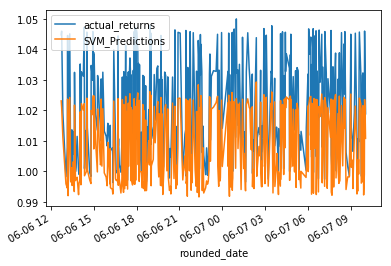

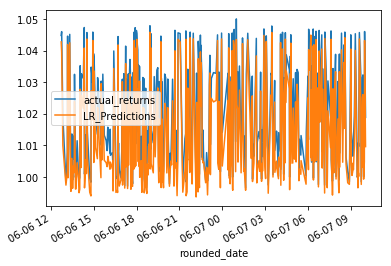

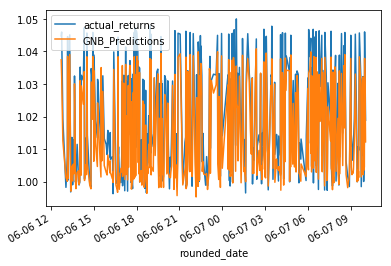

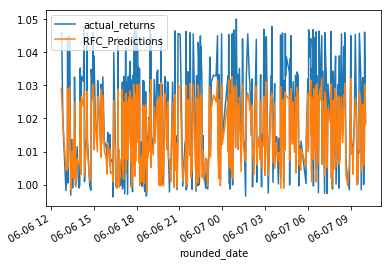

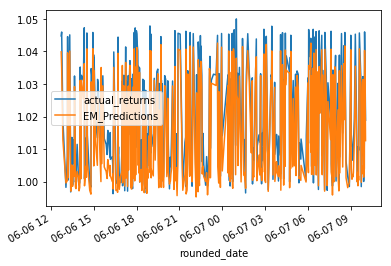

In [148]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "SVM_Predictions"]]).cumprod().plot()
(1 + predictions_df[["actual_returns", "LR_Predictions"]]).cumprod().plot()
(1 + predictions_df[["actual_returns", "GNB_Predictions"]]).cumprod().plot()
(1 + predictions_df[["actual_returns", "RFC_Predictions"]]).cumprod().plot()
(1 + predictions_df[["actual_returns", "EM_Predictions"]]).cumprod().plot()

In [151]:
# Initialize trade_type column for buys and sells
total_data['trade_type'] = np.nan

# Initialize variable to hold the previous_price
previous_price = 0


# Loop through the Pandas DataFrame and code the conditions of the trading strategy 
for index, row in total_data.iterrows():
    
    # buy if the previous price is 0 and Twitter Sentiment has Positive for 7 consecutive days.
    if previous_price == 0:
        total_data.loc[index, "trade_type"] = "buy"

    # buy if the current day price is less than the previous day price and Twitter Sentiment is greater than 0.02
    elif row["close"] < previous_price and row['polarity'] > 0.16:
        total_data.loc[index, "trade_type"] = "buy"

    # sell if the current day price is greater than the previous day price and Twitter Sentiment is less than 0.015
    elif row["close"] > previous_price and row['polarity'] <= 0.3:
        total_data.loc[index, "trade_type"] = "sell"

    elif row["close"] > previous_price and row['polarity'] > 0.4:
        total_data.loc[index, "trade_type"] = "hold"
        
    # else hold if the current day price is equal to the previous day price and Twitter Sentiment is Neutrual or Greater in 4 days
    else:
        total_data.loc[index, "trade_type"] = "hold"
    
    # reset the previous_price variable to the close price of the current row
    previous_price = row["close"]

    # if the index is the last index of the Dataframe, set the trade_type to sell
    if index == total_data.index[-1]:
        total_data.loc[index, "trade_type"] = "sell"


total_data

,close,polarity,sma_50,sma_100,actual_returns,sma_signal,Entry/Exit,Signal,trade_type
rounded_date,,,,,,,,,
2022-06-06 12:40:00,42492.45,0.202188,42260.3588,41933.8027,-0.000191,0.0,NaN,1,buy
2022-06-06 12:41:00,42492.69,0.062325,42269.5366,41944.2324,0.000006,0.0,0.0,1,sell
2022-06-06 12:42:00,42514.23,0.116947,42279.1890,41954.6393,0.000507,0.0,0.0,1,sell
2022-06-06 12:43:00,42480.58,0.185000,42289.2902,41964.5870,-0.000791,0.0,0.0,-1,buy
2022-06-06 12:44:00,42457.38,0.148804,42297.7762,41974.1159,-0.000546,0.0,0.0,-1,hold
...,...,...,...,...,...,...,...,...,...
2022-06-07 10:02:00,43605.19,0.100042,43654.3074,43719.2186,-0.000374,0.0,0.0,-1,hold
2022-06-07 10:03:00,43618.78,0.074920,43652.7642,43717.5456,0.000312,0.0,0.0,1,sell
2022-06-07 10:04:00,43616.58,0.090621,43651.2382,43715.6478,-0.000050,0.0,0.0,-1,hold


In [150]:
plot_df = total_data.reset_index()

# Create a Sell Plot
sell = plot_df[plot_df["trade_type"] == "sell"]["close"].hvplot.scatter(
    color="red",
    marker="v",
    size=200,
    legend=False,
    ylabel="Price in $",
    width=1000,
    height=400)

# Create a Buy Plot
buy = plot_df[plot_df["trade_type"] == "buy"]["close"].hvplot.scatter(
    color="green",
    marker="v",
    size=200,
    legend=False,
    ylabel="Price in $",
    width=1000,
    height=400)

# Create a Hold Plot
neu = plot_df[plot_df["trade_type"] == "hold"]["close"].hvplot.scatter(
    color="orange",
    marker="v",
    size=200,
    legend=False,
    ylabel="Price in $",
    width=1000,
    height=400) 

security_close = plot_df[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)    

# Create the overlay plot
buy_sell_plot = buy * sell * neu * security_close

# Show the plot
buy_sell_plot.opts(
    title="Bitcoin - Buy, Sell and Hold Chart"
)     

:Overlay
   .Scatter.Close.I   :Scatter   [index]   (close)
   .Scatter.Close.II  :Scatter   [index]   (close)
   .Scatter.Close.III :Scatter   [index]   (close)
   .Curve.I           :Curve   [index]   (close)